# Accent-Aware Speech Recognition System
This notebook implements a deep learning-based ASR system with speaker adaptation and data augmentation.

In [ ]:
# Install required packages
!pip install librosa torchaudio jiwer noisereduce datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
# Imports
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchaudio
import noisereduce as nr
from jiwer import wer
from sklearn.model_selection import train_test_split

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Set dataset paths
DATA_PATH = "/content/drive/MyDrive/Commonvoice/"
CLIPS_PATH = os.path.join(DATA_PATH, "clips")

In [9]:
# Load metadata
df = pd.read_csv(os.path.join(DATA_PATH, "validated.tsv"), sep="\t")
df = df[['path', 'sentence', 'accents']].dropna().head(1000)
df.head()

,path,sentence,accents
0,common_voice_en_41923025.mp3,"He was born at Wichenford, in Worcestershire, ...",United States English
1,common_voice_en_42356358.mp3,The Portuguese division was overrun and withdr...,United States English
3,common_voice_en_41921729.mp3,His sporting interests outside of cricket incl...,England English
4,common_voice_en_42528393.mp3,The following year he was elected to be part o...,United States English
5,common_voice_en_42006138.mp3,A healthy diet combined with lots of exercise ...,"Australian English,Canadian English"


In [10]:
# Clean audio
def clean_audio(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    y_denoised = nr.reduce_noise(y=y, sr=sr)
    y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=20)
    return y_trimmed, sr

In [11]:
# Data augmentation
def augment_audio(audio, sr):
    return [
        librosa.effects.pitch_shift(audio, sr, n_steps=4),
        librosa.effects.time_stretch(audio, rate=1.2),
        audio + 0.005 * np.random.randn(len(audio))
    ]

In [12]:
# Preprocess audio to spectrogram
def preprocess_audio(waveform, sample_rate=16000):
    spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(torch.tensor(waveform))
    spectrogram = torchaudio.transforms.AmplitudeToDB()(spectrogram)
    return spectrogram

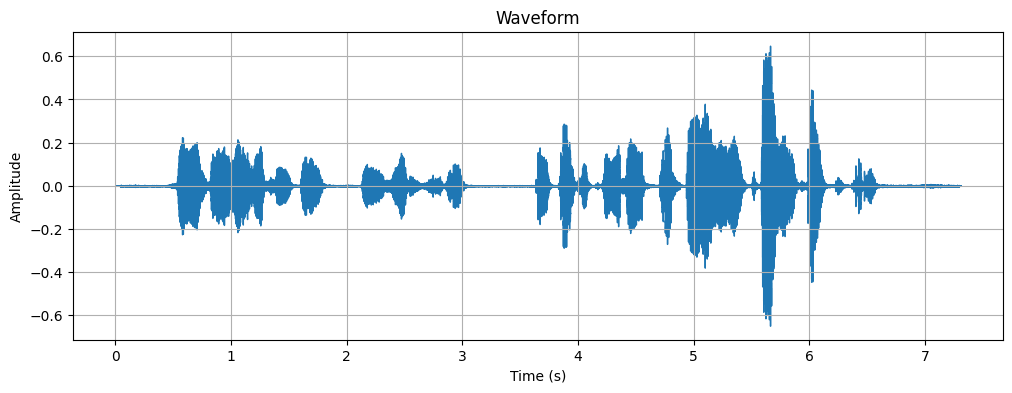

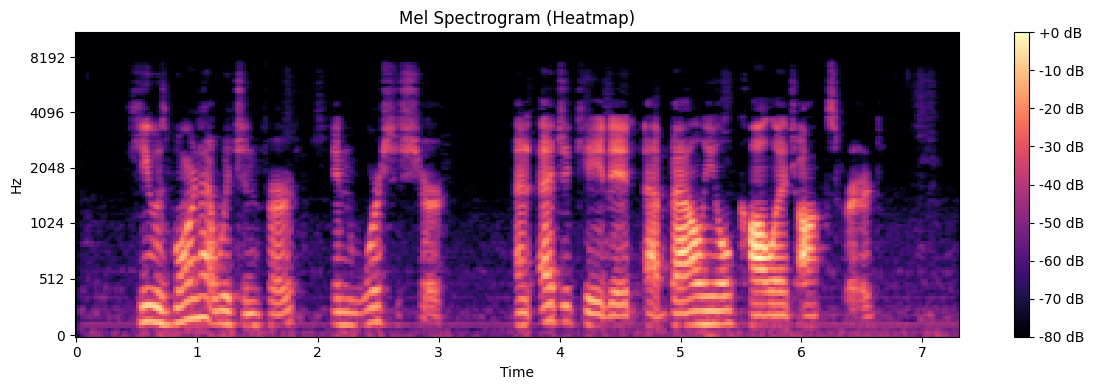

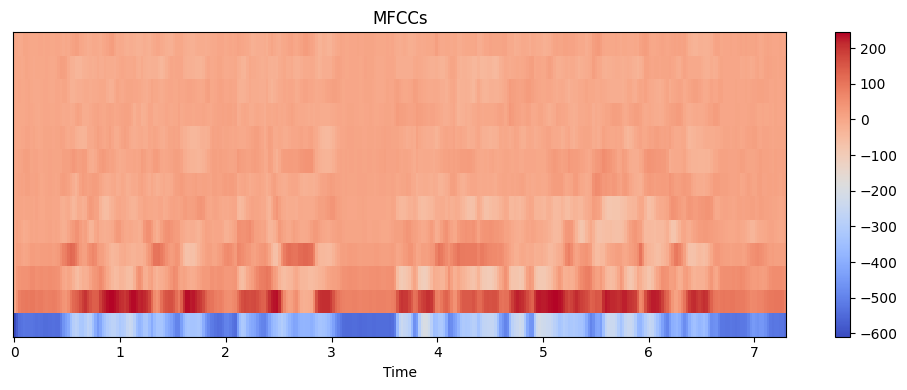

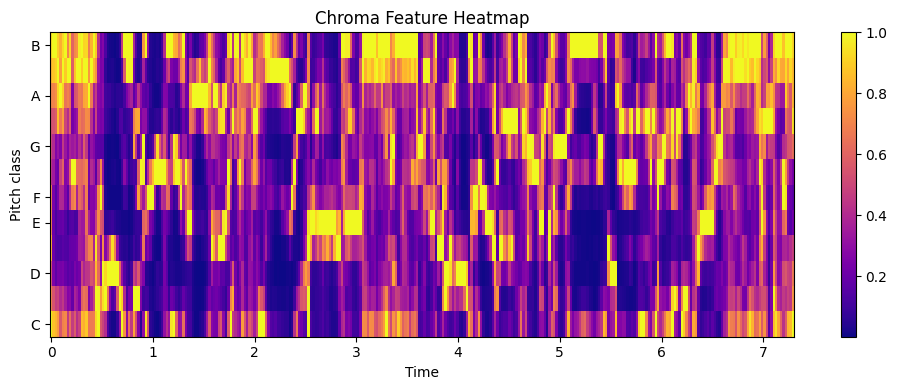

In [13]:
# Load a sample audio file
sample_path = os.path.join(CLIPS_PATH, df['path'].iloc[0])
audio, sr = librosa.load(sample_path)

# Plot waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Plot Mel Spectrogram (as heatmap)
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram (Heatmap)")
plt.tight_layout()
plt.show()

# Plot MFCCs
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='coolwarm')
plt.colorbar()
plt.title("MFCCs")
plt.tight_layout()
plt.show()

# Plot Chroma Features
chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr, cmap='plasma')
plt.colorbar()
plt.title("Chroma Feature Heatmap")
plt.tight_layout()
plt.show()


In [14]:
# Model: CNN + RNN
import torch.nn as nn

class CNNRNN_ASR(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, output_dim=29):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.rnn = nn.LSTM((input_dim // 4) * 64, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = self.cnn(x.unsqueeze(1))
        b, c, f, t = x.shape
        x = x.permute(0, 3, 1, 2).contiguous().view(b, t, -1)
        x, _ = self.rnn(x)
        return self.classifier(x)

In [19]:
import torch
import torch.nn as nn

def train(model, dataloader, epochs=5):
    print("Starting training...", flush=True)  # Debug print

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CTCLoss(blank=28)

    try:
        length = len(dataloader)
        print(f"Dataloader has {length} batches.", flush=True)
    except Exception as e:
        print(f"Error checking dataloader length: {e}", flush=True)
        return

    for epoch in range(epochs):
        total_loss = 0.0
        print(f"Epoch {epoch+1}/{epochs} started.", flush=True)

        for batch_idx, batch in enumerate(dataloader):
            try:
                if len(batch) != 4:
                    print(f"Batch {batch_idx} has unexpected structure: {batch}", flush=True)
                    continue

                inputs, targets, in_lens, tar_lens = batch

                optimizer.zero_grad()
                outputs = model(inputs).log_softmax(2)
                loss = criterion(outputs, targets, in_lens, tar_lens)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                print(f"  Batch {batch_idx + 1}: Loss = {loss.item():.4f}", flush=True)

            except Exception as e:
                print(f"  Error in batch {batch_idx}: {e}", flush=True)
                continue

        print(f"Epoch {epoch + 1} completed. Total Loss = {total_loss:.4f}", flush=True)


In [16]:
def evaluate(model, dataloader, decode_fn):
    model.eval()
    references, hypotheses = []
    total_chars = correct_chars = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)  # [B, T, C]
            predicted_indices = outputs.argmax(dim=-1)  # [B, T]

            # Decode both predictions and targets to text
            for pred_seq, target_seq in zip(predicted_indices, targets):
                pred_text = decode_fn(pred_seq)
                target_text = decode_fn(target_seq)

                references.append(target_text)
                hypotheses.append(pred_text)

                # Character-level accuracy
                min_len = min(len(pred_text), len(target_text))
                correct = sum(p == t for p, t in zip(pred_text[:min_len], target_text[:min_len]))
                correct_chars += correct
                total_chars += max(len(pred_text), len(target_text))

    wer_score = wer(references, hypotheses)
    accuracy = (correct_chars / total_chars) * 100 if total_chars > 0 else 0.0

    print("WER: {:.2f}%".format(wer_score * 100))
    print("Char-Level Accuracy: {:.2f}%".format(accuracy))


In [17]:
from tqdm import tqdm
import librosa

# Safely get audio duration and handle missing or unreadable files
durations = []

for p in tqdm(df['path']):
    full_path = os.path.join(CLIPS_PATH, p)
    try:
        duration = librosa.get_duration(path=full_path)  # updated keyword
    except Exception as e:
        print(f"Skipping {p}: {e}")
        duration = None
    durations.append(duration)

# Add duration column to DataFrame
df['duration'] = durations

# Drop rows with missing durations
df_clean = df.dropna(subset=['duration'])

# Export for Power BI
df_clean[['accents', 'duration']].to_csv("eda_accent_duration.csv", index=False)
print("Saved to eda_accent_duration.csv")
from google.colab import files
files.download("eda_accent_duration.csv")



  0%|          | 0/244 [00:00<?, ?it/s]<ipython-input-17-5e0061b1562c>:10: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audioread support is deprecated in librosa 0.10.0 and will be removed in version 1.0.
  duration = librosa.get_duration(path=full_path)  # updated keyword


Skipping common_voice_en_42356358.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42356358.mp3'


  7%|▋         | 16/244 [00:00<00:08, 27.54it/s]

Skipping common_voice_en_42528393.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42528393.mp3'
Skipping common_voice_en_42006138.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42006138.mp3'
Skipping common_voice_en_42555516.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42555516.mp3'
Skipping common_voice_en_41951792.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41951792.mp3'
Skipping common_voice_en_42446785.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42446785.mp3'
Skipping common_voice_en_41974998.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41974998.mp3'
Skipping common_voice_en_42020013.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/

 13%|█▎        | 32/244 [00:01<00:09, 22.02it/s]

Skipping common_voice_en_42593468.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42593468.mp3'
Skipping common_voice_en_42593505.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42593505.mp3'
Skipping common_voice_en_41958320.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41958320.mp3'
Skipping common_voice_en_41958333.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41958333.mp3'
Skipping common_voice_en_41969910.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41969910.mp3'
Skipping common_voice_en_42182410.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42182410.mp3'
Skipping common_voice_en_42264420.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/

 17%|█▋        | 41/244 [00:04<00:39,  5.18it/s]

Skipping common_voice_en_42604282.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42604282.mp3'
Skipping common_voice_en_42510046.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42510046.mp3'
Skipping common_voice_en_42510071.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42510071.mp3'
Skipping common_voice_en_42510072.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42510072.mp3'


 20%|██        | 50/244 [00:06<00:42,  4.56it/s]

Skipping common_voice_en_42095418.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42095418.mp3'
Skipping common_voice_en_42095438.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42095438.mp3'
Skipping common_voice_en_42356474.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42356474.mp3'
Skipping common_voice_en_42356503.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42356503.mp3'
Skipping common_voice_en_42527824.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42527824.mp3'
Skipping common_voice_en_42527894.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_42527894.mp3'
Skipping common_voice_en_42527906.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/

 45%|████▌     | 111/244 [00:11<00:03, 40.53it/s]

Skipping common_voice_en_41949226.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41949226.mp3'
Skipping common_voice_en_41984164.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41984164.mp3'
Skipping common_voice_en_41984166.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41984166.mp3'
Skipping common_voice_en_41984174.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41984174.mp3'
Skipping common_voice_en_41984175.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41984175.mp3'
Skipping common_voice_en_41984176.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41984176.mp3'
Skipping common_voice_en_41984186.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/

100%|██████████| 244/244 [00:28<00:00,  8.46it/s]

Skipping common_voice_en_41948210.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41948210.mp3'
Skipping common_voice_en_41948211.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41948211.mp3'
Skipping common_voice_en_41952158.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41952158.mp3'
Skipping common_voice_en_41952160.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41952160.mp3'
Skipping common_voice_en_41952161.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41952161.mp3'
Skipping common_voice_en_41952177.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/clips/common_voice_en_41952177.mp3'
Skipping common_voice_en_41952209.mp3: [Errno 2] No such file or directory: '/content/drive/MyDrive/Commonvoice/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>